# Score-based generative modeling with Stochastic Differential Equation (SDE)

In previous diffusion tutorials (DDPM, SMLD), we saw the learning of iteratively reversing the corruption of data to generate a clean image.<br>
In this tutorial, we see (interpret) these approaches through the lens of Stochastic Differential Equations (SDE).

By seeing the linkage between iterative process and stochastic differential equation (SDE), it enables us to consider these 2 different methods (DDPM and SMLD) from the same perspectives and same insights, and we can also improve training and image generation process by applying continuos SDE perspectives.

*(back to [index](https://github.com/tsmatz/diffusion-tutorials/))*

## Architecture & Method

Let's briefly follow theoretical aspects behind Score-based generative modeling through Stochastic Differential Equation (SDE) along with the original paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)].

### 1. Interpretation to Stochastic Differential Equation (SDE)

Up until now, we have learned two variations of diffusion models - DDPM and SMLD.<br>
In these two algorithms, diffusion process has a finite number of iterative operations in discrete manner.

It's known that many discrete-time algorithms have their associating differential equations in continuos manner.<br>
For example, recall an iterative process of gradient descent algorithm to find a minimum point in discrete manner, the limit of which satisfies some differential equation in continuos spaces.

And the ordinary differential equation can be solved by taking integrals.<br>
For instance, the differential equation $\frac{d\mathbf{x}(t)}{dt}=f(\mathbf{x}(t), t)$ can be solved by :

$\displaystyle \mathbf{x}(t) = \mathbf{x}(0) + \int_0^t f(\mathbf{x}(s), s) ds$

Same as above ordinary differential equation, stochastic differential equation (SDE) is the differential equation, in which term of stochastic process (e.g., white noise) is added.<br>
According to the paper, diffusion process can be modeled as the solution of the following stochastic differential equations (SDE) in continuous manner.

$\displaystyle \frac{d\mathbf{x}(t)}{dt} = f(\mathbf{x}(t), t) + g(t) \xi(t)$

where $\xi(t) \sim \mathcal{N}(\mathbf{0},\mathbf{I})$.

In this equation, $f(\mathbf{x}(t), t)$ is a vector called **drift** coefficient, and $g(t)$ is a scalar called **diffusion** coefficient.

We sometimes denote this equation as follows :

$\displaystyle d\mathbf{x} = f(\mathbf{x}, t)dt + g(t) d \mathbf{w} \;\;\;\;\;\; (1)$

where $\mathbf{w} = \xi(t) dt$ is Wiener process (i.e., Brownian motion).

Same as above ordinary differential equation, stochastic differential equation (SDE) can also be solved by taking integrals as follows.

$\displaystyle \mathbf{x}(t) = \mathbf{x}(0) + \int_0^t f(\mathbf{x}(s), s) ds + \int_0^t g(s) d \mathbf{w}$

where $\int \cdot d \mathbf{w}$ is an [Ito integral](https://en.wikipedia.org/wiki/It%C3%B4_calculus), the result of which is another stochastic process.

The solution $\mathbf{x}(t)$ is then also stochastic.

Same as above ordinary differential equations, stochastic iterations indiscrete manner are also written with stochastic differential equations (SDE) in continuous manner.<br>
According to [[Brian Anderson, 1982](https://www.sciencedirect.com/science/article/pii/0304414982900515)], when the forward iteration process is written by the equation (1), the reverse process is then given as follows. :

$\displaystyle d\mathbf{x} = \left[f(\mathbf{x}, t) - g(t)^2 \nabla_{\mathbf{x}} \log p_t(\mathbf{x})\right]dt + g(t)d\bar{\mathbf{w}} \;\;\;\;\;\; (2)$

where $\bar{\mathbf{w}}$ is Wiener process when time flows backwards from $T$ to $0$.

As you see, the drift coefficient is transformed to $\left[f(\mathbf{x}, t) - g(t)^2 \nabla_{\mathbf{x}} \log p_t(\mathbf{x})\right]$, and the diffusion coefficient remains the same scalar $g(t)$.

![Overview of score-based generative modeling through SDEs](./assets/sde_process.png)

*From: "[Score-based Generative Modeling Through Stochastic Differential Equations](https://arxiv.org/pdf/2011.13456)"*

As we saw in [SMLD tutorial](./03-smld.ipynb), $\nabla_{\mathbf{x}} \log p_t(\mathbf{x})$ is replaced by score function (neural network) $\mathbf{s}_{\theta}(\mathbf{x}, t)$, and we can then get the reverse iteration process even in discrete manner.<br>
Therefore, once we have obtained stochastic differential equation (SDE) of diffusion forward process, we can obtain the reverse process analytically by switching to the continuous objective, or numerically by switching to the discrete objective.

In our example (in this notebook), we'll implement the continuous objective.

### 2. Stochastic Differential Equation (SDE) in DDPM

Through this notebook, we'll see the method in DDPM (Denoising Diffusion Probabilistic Models) example.

First, recall iterative forward process of DDPM as follows. (See previous [DDPM tutorial](./02-ddpm.ipynb).)

$\displaystyle \mathbf{x}_i = \sqrt{1-\beta_i} \mathbf{x}_{i-1} + \sqrt{\beta_i} \mathbf{z}_{i-1} \;\; (i=1,\ldots,N) \;\;\;\;\;\; (3)$

where $\beta_i = 1-\alpha_i$ and $\mathbf{z}_{i-1} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$.

Here we introduce an auxiliary function for noise scale, $\beta(t)$, as follows.

$\displaystyle \beta_i = \beta(t+\Delta t)\Delta t$

This function $\beta(t)$ intuitively is a continuous function illustrated as follows. (In the following picture, it assumes that the scaling of $\beta_i$ is linear.)<br>
In this definition, let $t \in \{ 0,\frac{1}{N},\ldots,\frac{N-1}{N} \}$ (i.e., $t \in [0,1]$) and $\beta_i=\frac{1}{N}\beta(\frac{i}{N})$<br>
When $N \to \infty$, then $\beta(t+\Delta t)\Delta t \to 0$.

![DDPM beta function in SDE](./assets/ddpm_beta_in_sde.png)

By using this function, we can now rewrite the equation (3) as follows.

$\displaystyle \mathbf{x}(t+\Delta t) = \sqrt{1-\beta(t+\Delta t)\Delta t} \cdot \mathbf{x}(t) + \sqrt{\beta(t+\Delta t)\Delta t} \cdot \mathbf{z}(t)$

By applying a linear appriximation at $\gamma=0$, you can approximate as $\sqrt{1-\gamma} \approx 1-\frac{1}{2}\gamma$.<br>
This approximation gives us :

$\displaystyle \mathbf{x}(t+\Delta t) $

$\displaystyle \approx \mathbf{x}(t) - \frac{1}{2} \beta(t+\Delta t)\Delta t \cdot \mathbf{x}(t) + \sqrt{\beta(t+\Delta t)\Delta t} \cdot \mathbf{z}(t)$

$\displaystyle \approx \mathbf{x}(t) - \frac{1}{2} \beta(t+\Delta t)\Delta t \cdot \mathbf{x}(t) + \sqrt{\beta(t)\Delta t} \cdot \mathbf{z}(t)$

Therefore, in the limit of $\Delta t \to 0$, it holds :

$\displaystyle d\mathbf{x} = -\frac{1}{2}\beta(t)\mathbf{x}dt + \sqrt{\beta(t)}d\mathbf{w} \;\;\;\;\;\; (4)$

In DDPM, therefore, the term $-\frac{1}{2}\beta(t)\mathbf{x}$ is a drift coefficient in the forward process, and $\sqrt{\beta(t)}$ is a diffusion coefficient in the forward process.

By applying equation (2), stochastic differential equation of the reverse process is then given by :

$\displaystyle d\mathbf{x}=-\beta(t)\left[\frac{1}{2}\mathbf{x} + \nabla_{\mathbf{x}} \log p_t(\mathbf{x})\right]dt + \sqrt{\beta(t)}d\bar{\mathbf{w}}$

By replacing $\nabla_{\mathbf{x}} \log p_t(\mathbf{x})$ with score function $\mathbf{s}_{\theta}(\mathbf{x}, t)$, you then get :

$\displaystyle d\mathbf{x}=-\beta(t)\left[\frac{1}{2}\mathbf{x} + \mathbf{s}_{\theta}(\mathbf{x},t)\right]dt + \sqrt{\beta(t)}d\bar{\mathbf{w}} \;\;\;\;\;\; (5)$

Here I don't go so far, but let's briefly see SMLD through SDE.<br>
In the case of SMLD, we don't have explicit forward diffusion steps, but recall the training in SMLD, in which noise $\mathcal{N}(\mathbf{0},\sigma^2 \mathbf{I})$ is given in the input.<br>
This implies that the perturbation of each noise scale in SMLD corresponds to the distribution in the following Markov chain.

$\displaystyle \mathbf{x}_i = \mathbf{x}_{i-1} + \sqrt{\sigma_i^2 - \sigma_{i-1}^2} \mathbf{z}_{i-1}$

This iteration gives us the following stochastic differential equation, and we can also consider the reverse process. (The result is identical to previous [SMLD tutorial](./03-smld.ipynb).)

$\displaystyle d\mathbf{x} = \sqrt{\frac{d[\sigma^2(t)]}{dt}}d\mathbf{w}$

This yields a process with exploding variance when $t \to \infty$, and this is called **Variance Exploding (VE) SDE**. In contrast, the equation (4) is called **Variance Preserving (VP) SDE**.

See Appendix B in the paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)] for more details.

> Note : However, [[Kawar et. al., 2022](https://arxiv.org/pdf/2201.11793)] indicates the equivalency of inference process between VE SDE and VP SDE. (The used model will mostly affect the result.)

### 3. Training in SDE (continuous objective)

With above linear $\beta(t)$ function, we now define :

$\displaystyle \bar{\beta}_{\min} = \min_{i \in \{0,1,\ldots,N-1\}} \beta(\frac{i}{N})$

$\displaystyle \bar{\beta}_{\max} = \max_{i \in \{0,1,\ldots,N-1\}} \beta(\frac{i}{N})$

(Here we also assume $t \in \{ 0,\frac{1}{N},\ldots,\frac{N-1}{N} \}$ (i.e., $t \in [0,1]$).)

With this notation, we can rewrite the equation (4) as follows.

$\displaystyle d\mathbf{x} = -\frac{1}{2}(\bar{\beta}_{\min} + t(\bar{\beta}_{\max} - \bar{\beta}_{\min}))\mathbf{x}dt + \sqrt{\bar{\beta}_{\min} + t(\bar{\beta}_{\max} - \bar{\beta}_{\min})}d\mathbf{w}$

By applying the equation in [[Hannes Risken, 1989](https://link.springer.com/book/10.1007/978-3-642-61544-3)], you can then get the following solution. (See the following note.) :

$\displaystyle \mathbf{x}(t)=e^{-\frac{1}{4}t^2(\bar{\beta}_{\max} - \bar{\beta}_{\min})-\frac{1}{2}t\bar{\beta}_{\min}} \mathbf{x}(0) + \left(1 - e^{-\frac{1}{2}t^2(\bar{\beta}_{\max} - \bar{\beta}_{\min})-t\bar{\beta}_{\min}}\right) \xi(t)$

where $\xi(t) \sim \mathcal{N}(\mathbf{0},\mathbf{I})$.

The perturbation kernel is then given by :

$p(\mathbf{x}(t)|\mathbf{x}(0)) = \mathcal{N}\left(\mathbf{x}(t) | e^{-\frac{1}{4}t^2(\bar{\beta}_{\max} - \bar{\beta}_{\min})-\frac{1}{2}t\bar{\beta}_{\min}} \mathbf{x}(0), \left(1 - e^{-\frac{1}{2}t^2(\bar{\beta}_{\max} - \bar{\beta}_{\min})-t\bar{\beta}_{\min}}\right) \mathbf{I}\right) \;\;\;\;\;\; (6)$

> Note : Suppose, the stochastic differential equation $\frac{d\mathbf{x}}{dt} = -a \mathbf{x} + b \xi(t) $ is given. The solution is then given by $\mathbf{x}(t) = \mathbf{x}(0) e^{-at} + b \int_0^t e^{-a(t-s)} \xi(s) ds$, according to the equation (3.7) in [[Hannes Risken, 1989](https://link.springer.com/book/10.1007/978-3-642-61544-3)].

In the training, we can pick up the noised data (samples) $\tilde{\mathbf{x}}$ from the marginal ditribution $p(\mathbf{x}(t)|\mathbf{x}(0))$, and we can then get the output of $\mathbf{s}_{\theta}(\tilde{\mathbf{x}}, t)$ (score function).

As we saw in [SMLD tutorial](./03-smld.ipynb), we can optimize the parameter $\theta$ as follows, when assuming $\mathbf{s}_{\theta}(\mathbf{x}, t) = \nabla_{\mathbf{x}} \log p_t(\mathbf{x})$.

$\displaystyle \theta^{\ast} = \arg \min_{\theta} \left\{ \lambda(t) \mathbb{E}\left[ \left\|\mathbf{s}_{\theta}(\tilde{\mathbf{x}}, t) + \frac{\mathbf{z}}{\sigma(t)} \right\|^2 \right] \right\}$

where $\lambda(t)$ is a weighting function, and $\sigma(t)$ is a standard deviation at $t$.

The weighting of score-matching loss, $\lambda(t)$, is determined by the training policy, and see Table 1 in the paper "[Maximum Likelihood Training of Score-Based Diffusion Models](https://arxiv.org/pdf/2101.09258)" for details.<br>
In our example (in this notebook), we apply the following $\lambda(t)$ as the weighting of loss in the training.

$\displaystyle \lambda(t) = 1 - e^{-\frac{1}{2}t^2(\bar{\beta}_{\max} - \bar{\beta}_{\min})-t\bar{\beta}_{\min}} = \sigma(t)^2$

As a result, we then get the optimal $\theta$ as follows.

$\displaystyle \theta^{\ast} = \arg \min_{\theta} \left\{ \mathbb{E}\left[ \left\|\sigma(t)\mathbf{s}_{\theta}(\tilde{\mathbf{x}}, t) + \mathbf{z} \right\|^2 \right] \right\} \;\;\;\;\;\; (7)$

For more details, see Appendix C in the paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)].

### 4. Inference process in SDE

Now let's consider inference (image generation) process in SDE.

In the inference (prediction), several sampling strategies can be applied.<br>
In the following description, we'll see several of these strategies.

**Euler-Maruyama Sampling**

According to the paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)], you can use Euler-Maruyama sampling as the predictor for continuously-trained models to get better perfoirmance.

In the inference process, we should also assume the number of steps $N$, even when it's continuous.<br>
Now we assume $dt = \frac{1}{N}$.

By applying equation (5), we can get the next sample by :

$\displaystyle \mathbf{x}_i = \mathbf{x}_{i+1} + \frac{\beta(t)}{N} \left[\frac{1}{2}\mathbf{x}_{i+1} + \mathbf{s}_{\theta^{\ast}}(\mathbf{x}_{i+1}, t_{i+1})\right] + \sqrt{\frac{\beta(t)}{N}} \mathbf{z} $

where $\theta^{\ast}$ is the optimized (trained) parameters and $\mathbf{z} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$.

**Ancestral Sampling**

Let's consider another sampling strategy which can be used in discrete objectives.

First we transform the equation (5) into the iterative updates as follows :

$\displaystyle \mathbf{x}(t) - \mathbf{x}(t-\Delta t) = -\beta(t)\Delta t\left[\frac{1}{2}\mathbf{x}(t) + \nabla_{\mathbf{x}} \log p_t(\mathbf{x}(t))\right] - \sqrt{\beta(t)\Delta t}\cdot\mathbf{z}(t)$

$\displaystyle \mathbf{x}(t-\Delta t) = \mathbf{x}(t) + \beta(t)\Delta t\left[\frac{1}{2}\mathbf{x}(t) + \nabla_{\mathbf{x}} \log p_t(\mathbf{x}(t))\right] + \sqrt{\beta(t)\Delta t}\cdot\mathbf{z}(t)$

$\displaystyle \mathbf{x}(t-\Delta t) = \left[1+\frac{\beta(t)\Delta t}{2}\right] \mathbf{x}(t) + \beta(t)\Delta t \nabla_{\mathbf{x}} \log p_t(\mathbf{x}(t)) + \sqrt{\beta(t)\Delta t}\cdot\mathbf{z}(t)$

This result can then be written in discrete manner as follows. :

$\displaystyle \mathbf{x}_{i-1} = \left(1+\frac{\beta_i}{2}\right)\mathbf{x}_i + \beta_i \mathbf{s}_{\theta^{\ast}}(\mathbf{x}_i, i) + \sqrt{\beta_i} \mathbf{z}_i \;\;\;\;\;\; (8)$

Finally, assuming that $\beta_i = \beta(t+\Delta t)\Delta t \ll 1$, we get:

$\displaystyle \mathbf{x}_{i-1}$

$\displaystyle \approx \left(1+\frac{\beta_i}{2}\right)\mathbf{x}_i + \beta_i \mathbf{s}_{\theta^{\ast}}(\mathbf{x}_i, i) + \frac{\beta_i^2}{2} \mathbf{s}_{\theta^{\ast}}(\mathbf{x}_i, i) + \sqrt{\beta_i} \mathbf{z}_i$

$\displaystyle =\left(1+\frac{\beta_i}{2}\right)\left(\mathbf{x}_i+\beta_i\mathbf{s}_{\theta^{\ast}}(\mathbf{x}_i, i)\right) + \sqrt{\beta_i} \mathbf{z}_i$

By applying a linear appriximation $(\sqrt{1-\gamma})^{-1} \approx 1+\frac{1}{2}\gamma$ (at $\gamma=0$), we then get :<br>

$\displaystyle \mathbf{x}_{i-1} \approx \frac{1}{\sqrt{1-\beta_i}}\left(\mathbf{x}_i+\beta_i\mathbf{s}_{\theta^{\ast}}(\mathbf{x}_i, i)\right) + \sqrt{\beta_i} \mathbf{z}_i \;\;\;\;\;\; (9)$

This sampling formula is called ancestral sampler, which corresponds to the sampling method discussed in [DDPM tutorial](./02-ddpm.ipynb).

**Reverse Diffusion Sampling**

The paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)] also proposes another sampling method called reverse diffusion sampler, which can also be used in discrete objectives. (The paper says that the reverse diffusion sampler performs better than above ancestral sampler.)

By above equation (3), we now get :

$\displaystyle \mathbf{x}_{i+1} - \mathbf{x}_i = (\sqrt{1-\beta_i} - 1) \mathbf{x}_i + \sqrt{\beta_i} \mathbf{z}_i$

This implies that both the drift term $\mathbf{f}_i(\mathbf{x}_i)$ and the diffusion term $\mathbf{G}_i$ are respectively written as follows in discrete manner.

$\displaystyle \mathbf{f}_i(\mathbf{x}_i) = (\sqrt{1-\beta_i} - 1) \mathbf{x}_i$

$\displaystyle \mathbf{G}_i = \sqrt{\beta_i}$

By applying these term on equation (2) (i.e., reverse process SDE), we now get :

$\displaystyle \mathbf{x}_i$

$\displaystyle = \mathbf{x}_{i+1} - \mathbf{f}_{i+1}(\mathbf{x}_{i+1}) + \mathbf{G}_{i+1}\mathbf{G}_{i+1}^T \mathbf{s}_{\theta^{\ast}}(\mathbf{x}_{i+1}, i+1) + \mathbf{G}_{i+1}\mathbf{z}_{i+1}$

$\displaystyle = (2 - \sqrt{1-\beta_{i+1}})\mathbf{x}_{i+1} + \beta_{i+1} \mathbf{s}_{\theta^{\ast}}(\mathbf{x}_{i+1}, i+1) + \sqrt{\beta_{i+1}}\mathbf{z}_{i+1} \;\;\;\;\;\; (10)$

(For more details, see Appendix E in the paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)].)

> Note : This result is also obtained by applying linear approximation $\sqrt{1-\gamma} \approx 1-\frac{1}{2}\gamma$ in equation (8).

**Predictor-Corrector (PC) sampling framework**

Considering general-purpose SDE solver in reverse-time SDE, we can combine any numerical SDE solvers (which is called a predictor) with score-based MCMC approaches (which is called a corrector).

For exmaple, the following algorithm is a combination of reverse diffusion predictor and Langevin MCMC corrector.<br>
In this combination, the predictor part comes from above equation (10), and the corrector part comes from Langevin equation (i.e., equation (1) in [previous notebook](./03-smld.ipynb)). Here the corrector is applied for generating true distribution by MCMC approach.

![Predictor-corrector algorithm example](./assets/sde_predictor_corrector.png)

*From: "[Score-based Generative Modeling Through Stochastic Differential Equations](https://arxiv.org/pdf/2011.13456)"*

By seeing in this perspective, vanilla DDPM (discussed in [DDPM tutorial](./02-ddpm.ipynb)) consists of ancestral predictor (see above) and no corrector (i.e., identity corrector). On contrary,  vanilla SMLD (discussed in [SMLD tutorial](./03-smld.ipynb)) consists of no predictor (i.e., identity predictor) and Langevin dynamics corrector.

In our example (in this notebook), we don't build any general-purpose solver, and just use Euler-Maruyama predictor.

For more details, see Appendix G in the paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)].

## Build and Train model

Now let's see the code (implementation) step-by-step with description of theoretical aspect.<br>
In this implementation, we don't build generic SDE solver, and we just build code only for continuous objective.

> Note : See [here](https://github.com/yang-song/score_sde) for official implementation, in which other perspectives (including discrete objectives) are also involved.

Before we start, we need to install the required packages.

In [ ]:
!pip install torch torchvision numpy matplotlib tqdm

### 1. Load data

We load images (CIFAR-10) dataset and dataloader.<br>
Each batch has shape ```[batch_size, 3, 32 32]```.

In [1]:
import torch
from torchvision import datasets, transforms

batch_size = 128

dataset = datasets.CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


Now I show 100 examples.

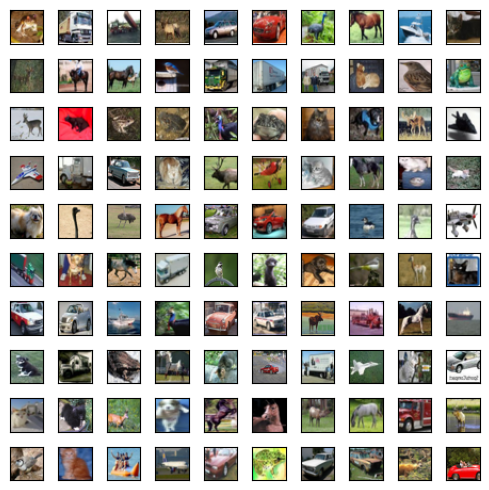

In [2]:
import numpy as np
import matplotlib.pyplot as plt

"""
for _, (data, _) in enumerate(loader):
    images = data[:3]
    break
for i in images:
    channel_last = np.transpose(i.numpy(), (1, 2, 0)) # (C, H, W) --> (H, W, C)
    plt.figure(figsize = (0.4,0.4))
    plt.imshow(channel_last)
    plt.show()
"""
num_row = 10
num_col = 10
fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
tmp_loader = torch.utils.data.DataLoader(dataset, batch_size=num_row*num_col, shuffle=False)
for data, _ in tmp_loader:
    for i in range(num_row*num_col):
        image = data[i].numpy()
        channel_last = np.transpose(image, (1, 2, 0)) # (C, H, W) --> (H, W, C)
        row = i//num_col
        col = i%num_col
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(channel_last)
    break
plt.tight_layout()
plt.show()
del tmp_loader

### 2. Build $\mathbf{s}_{\theta}$ (U-Net)

Now let's build a score function (neural network architecture) $\mathbf{s}_{\theta}(\mathbf{x}, t)$ for SDE.

In this example, we build a model (DDPM++ cont.) used in the paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)].<br>
This architecture is mostly based on the model in [DDPM tutorial](./02-ddpm.ipynb) (which is from [[Ho et al., 2020](https://arxiv.org/pdf/2006.11239)]).

First we build time embeddings.

Same as [DDPM tutorial](./02-ddpm.ipynb), each blocks in the network also receive time embedding, but time $t \in [0, 1]$ is continuous and we can't then apply regular positional embedding (encoding) seen in [DDPM tutorial](./02-ddpm.ipynb).<br>
Instead of applying positional embedding, hence, we then apply the following random Fourier features embeddings.

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#
# See https://arxiv.org/pdf/2006.10739
# (Gaussian version)
#
import math

class FourierFeatureEmbedding(nn.Module):
    def __init__(
        self,
        base_dim,   # 128
        scale=16.0, # 16  (see the paper in https://arxiv.org/pdf/2011.13456)
    ):
        super().__init__()

        # randomly sampled b
        # (no learnable parameters, but it must be saved !)
        self.b = nn.Parameter(
            torch.randn(base_dim) * scale,
            requires_grad=False
        )

    def forward(self, t):
        t_log = torch.log(t) # (apply as uniform-log variables)
        out = t_log[:, None] * self.b[None, :] # shape: [batch_size, base_dim]
        out = out * 2 * math.pi                # shape: [batch_size, base_dim]
        out = torch.cat([
            torch.sin(out),
            torch.cos(out)
        ], dim=-1)                             # shape: [batch_size, base_dim*2]
        return out

The model is based on the model in [DDPM tutorial](./02-ddpm.ipynb), but it's modified from the original one to improve performance.<br>
The following shows a list of modification from original DDPM.

- Residual blocks (including downsampling and upsampling) are replaced with ones in BigGAN architecture [[Brock et. al., 2018](https://arxiv.org/pdf/1809.11096)].<br>
  For instance, downsampling and upsampling are realized by average pooling. (See Appendix B in [[Brock et. al., 2018](https://arxiv.org/pdf/1809.11096)].)
- The number of residual blocks in each resolution is increased from 2 to 4.
- Rescaling residual connections with $\frac{1}{\sqrt{2}}$.

![DDPM++ cont. network](./assets/sde_ddpmpp.png)

Thus, the following source code is mostly from [DDPM tutorial](./02-ddpm.ipynb), but above modifications are also applied.

In official implementation, it also includes the implementation of progressive growing and anti-aliasing based on Finite Impulse Response (shortly, FIR) in StyleGAN architecture, but here I don't apply these architectures. (For more details, see Appendix H.1 in the paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)].)

In [5]:
class ResnetBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        num_norm_groups, # 32
        time_embedding_dim, # 512
        updown=None, # specify "down" when downsampling and "up" when upsampling
    ):
        super().__init__()

        assert (updown is None) or (updown == "down") or (updown == "up")
        self.updown = updown

        # for normalization
        self.norm1 = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=in_channel,
            eps=1e-06,
        )
        self.norm2 = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=out_channel,
            eps=1e-06,
        )

        # for applying conv
        self.conv1 = nn.Conv2d(
            in_channel,
            out_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.conv2 = nn.Conv2d(
            out_channel,
            out_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

        # for adding time condition
        self.linear_time = nn.Linear(time_embedding_dim, out_channel)

        # for residual block
        if (updown is not None) or (in_channel != out_channel):
            self.conv_src = nn.Conv2d(
                in_channel,
                out_channel,
                kernel_size=1,
                stride=1,
                padding=0,
            )
        else:
            self.conv_src = None

    def forward(self, x, t_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            input x
        t_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            time embeddings
        """

        channel = x.size(dim=1)
        height = x.size(dim=2)
        width = x.size(dim=3)

        # apply group norm
        out = self.norm1(x)
        out = F.silu(out)

        # transform in each cases
        # (x_trans is used in last residual layer.)
        if self.updown == "down":
            out = F.avg_pool2d(out, (2, 2))
            x_trans = F.avg_pool2d(x, (2, 2))
        elif self.updown == "up":
            out = out[:,:,:,None,:,None]
            out = out.repeat(1, 1, 1, 2, 1, 2)
            out = torch.reshape(out, (-1, channel, height*2, width*2))
            x_trans = x[:,:,:,None,:,None]
            x_trans = x_trans.repeat(1, 1, 1, 2, 1, 2)
            x_trans = torch.reshape(x_trans, (-1, channel, height*2, width*2))
        else:
            x_trans = x

        # apply conv
        out = self.conv1(out)

        # adjust time embedding
        t_e = F.silu(t_emb)
        t_e = self.linear_time(t_e)
        t_e = t_e[:, :, None, None]
        out = out + t_e

        # apply dropout + conv
        out = self.norm2(out)
        out = F.silu(out)
        out = F.dropout(out, p=0.1, training=self.training)
        out = self.conv2(out)

        # apply residual
        if self.conv_src is not None:
            x_trans = self.conv_src(x_trans)
        out = out + x_trans

        # rescale
        out = out / math.sqrt(2.0)

        return out

#
# For the implementation of multi-head attention,
# see https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb
#
class AttentionBlock(nn.Module):
    def __init__(
        self,
        channel,
        num_norm_groups, # 32
    ):
        super().__init__()

        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=channel,
            eps=1e-06,
        )

        self.q_layer = nn.Linear(channel, channel)
        self.k_layer = nn.Linear(channel, channel)
        self.v_layer = nn.Linear(channel, channel)

        self.output_linear = nn.Linear(channel, channel, bias=False)

    def forward(self, x):
        channel = x.size(dim=1)
        height = x.size(dim=2)
        width = x.size(dim=3)

        out = self.norm(x)

        # reshape : (N,C,H,W) --> (N,H*W,C)
        out = out.permute(0, 2, 3, 1)
        out = out.view(-1, height*width, channel)

        # generate query/key/value
        q = self.q_layer(out)
        k = self.k_layer(out)
        v = self.v_layer(out)

        # compute Q K^T
        score = torch.einsum("bic,bjc->bij", q, k)

        # scale the result by 1/sqrt(channel)
        score = score / channel**0.5

        # apply softtmax
        score = F.softmax(score, dim=-1)

        # apply dot product with values
        out = torch.einsum("bij,bjc->bic", score, v)

        # apply final linear
        out = self.output_linear(out)

        # reshape : (N,H*W,C) --> (N,C,H,W)
        out = out.view(-1, height, width, channel)
        out = out.permute(0, 3, 1, 2)

        # apply residual
        out = out + x

        # rescale
        out = out / math.sqrt(2.0)

        return out

class ResnetAndAttention(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        num_norm_groups, # 32
        time_embedding_dim, # 512
        updown=None, # specify "down" when downsampling and "up" when upsampling
    ):
        super().__init__()

        self.updown = updown

        self.resnet = ResnetBlock(
            in_channel,
            out_channel,
            num_norm_groups,
            time_embedding_dim,
            updown,
        )
        self.attention = AttentionBlock(
            out_channel,
            num_norm_groups,
        )

    def forward(self, x, t_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            input x
        t_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            time embeddings
        """
        out = self.resnet(x, t_emb)
        out = self.attention(out)
        return out

In [6]:
class UNet(nn.Module):
    def __init__(
        self,
        source_channel, # 3
        unet_base_channel, # 128
        num_norm_groups, # 32
    ):
        super().__init__()

        ### for time embedding
        self.time_emb = FourierFeatureEmbedding(
            base_dim=unet_base_channel,
        )
        self.time_hidden = nn.Linear(
            unet_base_channel*2,
            unet_base_channel*4,
        )
        self.time_output = nn.Linear(
            unet_base_channel*4,
            unet_base_channel*4,
        )

        ### for unet main
        self.down_conv = nn.Conv2d(
            source_channel,
            unet_base_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.top_to_down = nn.ModuleList([
            # 1st layer
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(    # downsampling
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
                updown="down",
            ),
            # 2nd layer
            ResnetAndAttention(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(    # downsampling
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
                updown="down",
            ),
            # 3rd layer
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(    # downsampling
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
                updown="down",
            ),
            # 4th layer
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
        ])
        self.middle = nn.ModuleList([
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            AttentionBlock(
                channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
        ])
        self.bottom_to_up = nn.ModuleList([
            # 1st layer
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(    # upsampling
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
                updown="up",
            ),
            # 2nd layer
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(    # upsampling
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
                updown="up",
            ),
            # 3rd layer
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*3,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(    # upsampling
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
                updown="up",
            ),
            # 4th layer
            ResnetBlock(
                in_channel=unet_base_channel*3,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                time_embedding_dim=unet_base_channel*4,
            ),
        ])
        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=unet_base_channel,
            eps=1e-06,
        )
        self.up_conv = nn.Conv2d(
            unet_base_channel,
            source_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

    def forward(self, x, t):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            Gaussian-noised images
        t : torch.tensor((batch_size), dtype=float)
            time
        """

        buffer = []

        #
        # according to https://arxiv.org/pdf/1809.11096,
        # scale to zero-centered : [0, 1] to [-1, 1]
        #
        out = x * 2.0 - 1.0

        #
        # generate time embedding
        #
        time_embs = self.time_emb(t)
        time_embs = self.time_hidden(time_embs)
        time_embs = self.time_output(time_embs) # shape: [batch_size, unet_base_channel*4]

        #
        # Top-to-down
        #

        # apply down-convolution
        out = self.down_conv(out)
        buffer.append(out)
        # apply top-to-down
        for block in self.top_to_down:
            out = block(out, time_embs)
            buffer.append(out)

        #
        # Middle
        #
        for block in self.middle:
            if isinstance(block, ResnetBlock):
                out = block(out, time_embs)
            elif isinstance(block, AttentionBlock):
                out = block(out)
            else:
                raise Exception("Unknown block")

        #
        # Bottom-to-up
        #

        # apply bottom-to-up
        for block in self.bottom_to_up:
            if block.updown is None:
                buf = buffer.pop()
                out = torch.cat((out, buf), dim=1)
            out = block(out, time_embs)
        # apply up-convolution
        out = self.norm(out)
        out = F.silu(out)
        out = self.up_conv(out)

        #
        # back to original scaling: [-1, 1] to [0, 1]
        #
        out = out / 2.0 + 0.5

        assert not buffer

        return out

In [7]:
#
# Generate model
#
unet = UNet(
    source_channel=3,
    unet_base_channel=128,
    num_norm_groups=32,
).to(device)

### 3. Train (Optimize) $\mathbf{s}_{\theta}$

Now let's train $\mathbf{s}_{\theta}$.

As we saw above in the equation (7), we should optimize $\theta$ to minimize the following loss :

$\displaystyle \theta^{\ast} = \arg \min_{\theta} \left\{ \mathbb{E}\left[ \left\|\sigma(t)\mathbf{s}_{\theta}(\tilde{\mathbf{x}}, t) + \mathbf{z} \right\|^2 \right] \right\} \;\;\;\;\;\; (7)$

where

- $\sigma(t)^2 = 1 - e^{-\frac{1}{2}t^2(\bar{\beta}_{\max} - \bar{\beta}_{\min})-t\bar{\beta}_{\min}}$
- $\tilde{\mathbf{x}} = e^{-\frac{1}{4}t^2(\bar{\beta}_{\max} - \bar{\beta}_{\min})-\frac{1}{2}t\bar{\beta}_{\min}} \mathbf{x}(0) + \sigma(t) \mathbf{z}$ &nbsp;&nbsp;&nbsp;&nbsp; (where $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}))$

In this example, we assume $N=1000$, i.e. $\Delta t = 1 / 1000$. ($N$ is not used in the training, but it'll be used in the inference.)<br>
As we saw in [DDPM tutorial](./02-ddpm.ipynb), $\beta_{\min}=10^{-4}$ and $\beta_{\max}=0.02$ give us better performance, and I have then configured $\bar{\beta}_{\min} = 10^{-4} / \Delta t = 0.1$ and $\bar{\beta}_{\max} = 0.02 / \Delta t = 20$.

For time t, we pick up random $t \in [0,1]$ in each steps. In the real training, however, vanishing variance is occurred in equation (6) when $t \to 0$.<br>
Therefore, we pick up $t \in [\epsilon,1]$, in which $\epsilon$ is experimentally determined and the paper says that $\epsilon=10^{-5}$ will give us the better performance in the training.

(For parameter's settings, see Appendix C in the original paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)].)

> Note : I have stopped the training with 500 epochs, but please run more to get more high quality samples.<br>
> The training requires a few days to complete with a single GPU.

> Note : The paper [[Song, et. al., 2021](https://arxiv.org/pdf/2011.13456)] says that the exponential moving average (EMA) has a significant impact on model performance. (EMA is also applied in the implementation on [official repository](https://github.com/yang-song/score_sde).)<br>
> In order to simplify our code, EMA is not applied in this example. (Apply EMA in the production.)

In [8]:
import os

# initialize optimizer
opt = torch.optim.Adam(unet.parameters(), lr=2e-4)

# remove log file if exists
log_file = "train_loss.log"
if os.path.exists(log_file):
    os.remove(log_file)

# initialize parameters (see above)
beta_min = 0.1
beta_max = 20.0
eps = 1e-5

# loop
num_epochs = 500
for epoch_idx in range(num_epochs):
    epoch_loss = []
    for batch_idx, (data, _) in enumerate(loader):
        unet.train()
        opt.zero_grad()

        # pick up x
        x_0 = data.to(device)

        # generate time t (see above for epsilon)
        b = x_0.size(dim=0)
        t = torch.rand(b).to(device) * (1.0 - eps) + eps  # shape (batch_size)

        # get mean and standard deviation in \tilde{x}
        # (see equation (6))
        mean_x = torch.exp(-0.25 * t**2 * (beta_max - beta_min) - 0.5 * t * beta_min)  # shape (batch_size)
        std_x = torch.sqrt(1.0 - torch.exp(-0.5 * t**2 * (beta_max - beta_min) - t * beta_min))  # shape (batch_size)

        # get \tilde{x}
        z = torch.randn_like(x_0).to(device)
        x = mean_x[:, None, None, None] * x_0 + std_x[:, None, None, None] * z

        # get model output (score function's output)
        model_out = unet(x, t)

        # get loss
        loss = torch.square(std_x[:, None, None, None] * model_out + z)
        loss = torch.mean(loss, dim=(1,2,3))
        loss = torch.mean(loss)

        # optimize
        loss.backward()
        opt.step()

        # log
        epoch_loss.append(loss.item())
        print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, loss), end="\r")

    # finalize epoch (save log and checkpoint)
    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, epoch_average_loss))
    with open(log_file, "a") as f:
        for l in epoch_loss:
            f.write("%s\n" %l)
    torch.save(unet.state_dict(), f"sde_ddpmpp_{epoch_idx}.pt")

print("Done")

epoch1 (iter391) - loss 0.1170
epoch2 (iter391) - loss 0.0545
epoch3 (iter391) - loss 0.0620
epoch4 (iter391) - loss 0.0439
epoch5 (iter391) - loss 0.0379
epoch6 (iter391) - loss 0.0341
epoch7 (iter391) - loss 0.0314
epoch8 (iter391) - loss 0.0307
epoch9 (iter391) - loss 0.0291
epoch10 (iter391) - loss 0.0284
epoch11 (iter391) - loss 0.0308
epoch12 (iter391) - loss 0.0272
epoch13 (iter391) - loss 0.0268
epoch14 (iter391) - loss 0.0251
epoch15 (iter391) - loss 0.0249
epoch16 (iter391) - loss 0.0240
epoch17 (iter391) - loss 0.0239
epoch18 (iter391) - loss 0.0238
epoch19 (iter391) - loss 0.0229
epoch20 (iter391) - loss 0.0230
epoch21 (iter391) - loss 0.0228
epoch22 (iter391) - loss 0.0226
epoch23 (iter391) - loss 0.0219
epoch24 (iter391) - loss 0.0220
epoch25 (iter391) - loss 0.0218
epoch26 (iter391) - loss 0.0212
epoch27 (iter391) - loss 0.0211
epoch28 (iter391) - loss 0.0209
epoch29 (iter391) - loss 0.0204
epoch30 (iter391) - loss 0.0208
epoch31 (iter391) - loss 0.0204
epoch32 (iter391)

Show loss transition of the first 10 epochs in training.

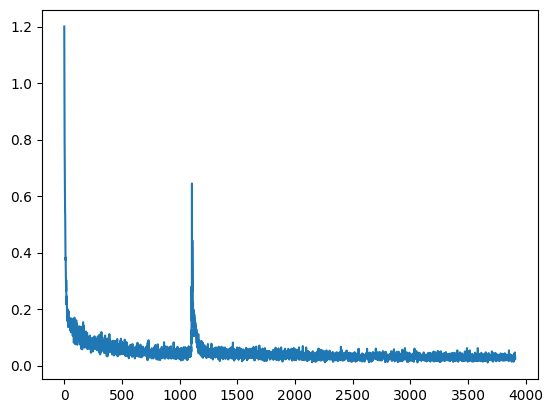

In [9]:
with open(log_file, "r") as f:
    all_loss = [float(line) for line in f]
num_rec = len(all_loss) * 10 // num_epochs
plt.plot(all_loss[:num_rec])

## Image generation with trained model

Now let's create images using above trained model.

As I have mentioned above, we can get the next sample by :

$\displaystyle \mathbf{x}_i = \mathbf{x}_{i+1} + \frac{\beta(t)}{N} \left[\frac{1}{2}\mathbf{x}_{i+1} + \mathbf{s}_{\theta^{\ast}}(\mathbf{x}_{i+1}, t_{i+1})\right] + \sqrt{\frac{\beta(t)}{N}} \mathbf{z} $

where $\theta^{\ast}$ is the trained parameters and $\mathbf{z} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$.

In this equation, $\beta(t)$ is obtained by : $\bar{\beta}_{\min} + t(\bar{\beta}_{\max} - \bar{\beta}_{\min})$.

The paper says that $\epsilon=10^{-3}$ will give us the better performance in the inference, and I have then set ```eps=0.001```.

100%|████████████████████████████████████████████████████████████| 1000/1000 [06:45<00:00,  2.47it/s]


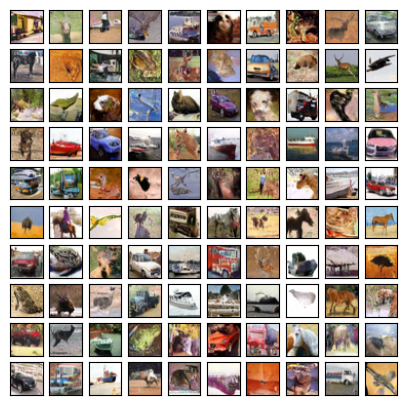

In [10]:
import tqdm

N = 1000

def run_inference(unet, x_0, beta_min, beta_max, eps, N):
    unet.eval()

    t_steps = torch.linspace(1.0, 0.0, N).to(device) * (1.0 - eps) + eps
    x = x_0
    b = x_0.size(dim=0)
    with torch.no_grad():
        # (showing progress, because it needs a lot of time.)
        for i, t in tqdm.tqdm(enumerate(t_steps), total=N):
            model_out = unet(x, t.repeat(b))
            beta_t = beta_min + (beta_max - beta_min) * t
            z = torch.randn_like(x).to(device)
            if i == N-1:
                x = x + (beta_t / N) * (0.5 * x + model_out)
            else:
                x = x + (beta_t / N) * (0.5 * x + model_out) + torch.sqrt(beta_t / N) * z

    # clip
    x = torch.clamp(x, min=0.0, max=1.0)
    return x

num_row = 10
num_col = 10

# initialize x_0
x_0 = torch.randn(num_row*num_col, 3, 32, 32).to(device)
# generate images
x = run_inference(unet, x_0, beta_min, beta_max, eps=0.001, N=N)
# draw
fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
for i in range(num_row*num_col):
    image = x[i].cpu().numpy()
    channel_last = np.transpose(image, (1, 2, 0)) # (C, H, W) --> (H, W, C)
    row = i//num_col
    col = i%num_col
    ax = axes[row, col]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(channel_last)